In [1]:
import os; import pathlib; from pathlib import Path; import numpy as np  ; import flopy    ; import matplotlib.pyplot as plt  ; import flopy.utils.binaryfile as bf
current_directory = os.getcwd();  print(current_directory)
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'  ; exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
Da_path = Path(r"E:\\15_REPOS\\00_BETAMI\\52_MT3D_El_Kadi\\ex_RES") ; Da_path.mkdir(exist_ok=True)
Db_path = Path(r"E:\\15_REPOS\\00_BETAMI\\52_MT3D_El_Kadi\\ex_RES\\11") ; Db_path.mkdir(exist_ok=True) ; output_folder = Db_path; ws = Db_path

E:\15_REPOS\00_BETAMI\52_MT3D_El_Kadi


In [2]:
perlen = 1000; nper=1; nstp = 50;         # tsmult = 1.0; nprs=-1;  nprobs = 10; cinact = -1; chkmas=True    # btn = flopy.mt3d.Mt3dBtn
tdis_rc_2 = np.linspace(0, perlen, nstp)  ; #  tdis_rc_2  # 

In [3]:
modelname = 'mf-mt'
mf = flopy.modflow.Modflow(modelname, model_ws=ws, exe_name = exe_name_mf)     
Lx = 1000; Ly = 1000; ztop = 0; zbot = -50; nlay = 1; nrow = 50; ncol = 50; delr = Lx/ncol; delc = Ly/nrow; 

delv = (ztop - zbot) / nlay                                                       ; botm = np.linspace(ztop, zbot, nlay + 1)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,top=ztop, botm = botm[1:])

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    ; ibound [:, :, 0] = -1   ; ibound [:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)    ; strt   [:, :, 0] = 10   ; strt   [:, :, -1] = 0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., ipakcb=53)      # LPF package
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
pumping_rate       = 1000           ; wcol = round(nrow/10)            ; wrow = round(ncol/2)  ; wel_sp = [[0, wrow, wcol, pumping_rate]] 
stress_period_data = {0: wel_sp}    ; wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)
pcg = flopy.modflow.ModflowPcg(mf)
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')  # MT3D
mf.write_input()   ;     success, buff = mf.run_model()

# _________________________________________________________________________________________________________________________________________

mt = flopy.mt3d.Mt3dms   (modflowmodel=mf, modelname=modelname, model_ws=ws,  exe_name=exe_name_mt, ftlfilename='mt3d_link.ftl')   
btn = flopy.mt3d.Mt3dBtn (mt, prsity=0.3, icbund = 1, sconc=0.0, ncomp=1 , 
                          perlen = 1000, nper=1, nstp = 50, tsmult = 1.0 , nprs = -1, nprobs = 10, cinact = -1, chkmas=True)   # cinact 
adv = flopy.mt3d.Mt3dAdv (mt, mixelm = -1, percel = 0.75)
dsp = flopy.mt3d.Mt3dDsp (mt, al=10.0, trpt=0.1, trpv=0.1, dmcoef=1e-09)
ssm_data = {}            ;   itype = flopy.mt3d.Mt3dSsm.itype_dict()     ; ssm_data[0] = [(0, wrow, wcol, 10.0, itype['WEL'])]
ssm      = flopy.mt3d.Mt3dSsm (mt, stress_period_data = ssm_data)
gcg = flopy.mt3d.Mt3dGcg (mt, cclose=1e-6)  # solver
mt.write_input ()       # ; mt.run_model  (silent=True)      
mt.run_model ()

FloPy is using the following executable to run the model: ..\..\..\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.6.01 3/4/2009, with FMP2              

 Using NAME file: mf-mt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/03/16 10:50:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/03/16 10:50:26
 Elapsed run time:  0.047 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: ..\..\..\bin\mt3d-usgs_1.1.0_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.1.0]   
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: mf-mt.nam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    20.

(False, [])

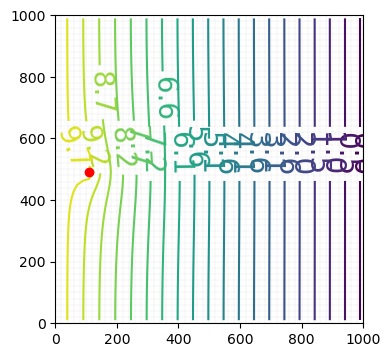

In [4]:
fig = plt.figure(figsize=(4,4), dpi=100)   ;   ax = fig.add_subplot(1, 1, 1, aspect='equal')
wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) 

hds = bf.HeadFile(Path(ws)       / f"{modelname}.hds")    ; times = hds.get_times() ;  head = hds.get_data(totim=times[-1])
cbb = bf.CellBudgetFile(Path(ws) / f"{modelname}.cbc")   

frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]   ;  fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge   (( frf, fff, None), mf, head)    

modelmap = flopy.plot.PlotMapView(model=mf, layer=0)  # , ax=ax        # modelmap = flopy.plot.ModelMap(model=mf, layer=0)
lc = modelmap.plot_grid(linewidth = 0.05) ; cs = modelmap.contour_array(head, levels=np.linspace(head.min(), head.max(), 21)) 
plt.clabel(cs, fontsize=20, fmt='%1.1f', zorder=1) ;   # quiver = modelmap.plot_vector(qx, qy)
plt.plot(wpt[0],wpt[1],'ro');   plt.show()

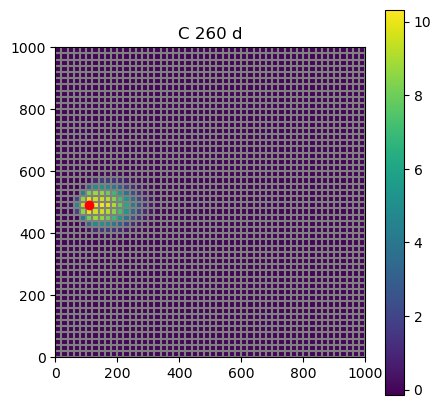

In [5]:
ucnobj = bf.UcnFile(Path(ws)  / 'MT3D001.UCN')
times = ucnobj.get_times() ; times1 = times[round(len(times)/4.)] ; times2 = times[round(len(times)/2.)]   ; times3 = times[-1] 
conc1 = ucnobj.get_data(totim=times1)                             ; conc2  = ucnobj.get_data(totim=times2) ; conc3  = ucnobj.get_data(totim=times3)

fig = plt.figure(figsize=(5,5), dpi=100)  ; ax = fig.add_subplot(1, 1, 1, aspect='equal')  ; modelmap = flopy.plot.PlotMapView(model=mf, layer=0)  
lc=modelmap.plot_grid() ; cs=modelmap.plot_array(conc1) ; plt.colorbar(cs) ; plt.plot(wpt[0],wpt[1],'ro') ; plt.title('C %g d' % times1) ; plt.show()

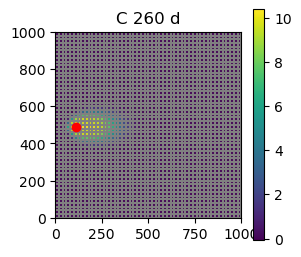

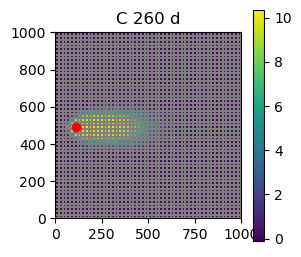

In [6]:
fig = plt.figure(figsize=(3,3), dpi=100)  ; ax = fig.add_subplot(1, 1, 1, aspect='equal')  ; modelmap = flopy.plot.PlotMapView(model=mf, layer=0)  
lc=modelmap.plot_grid() ; cs=modelmap.plot_array(conc2) ; plt.colorbar(cs) ; plt.plot(wpt[0],wpt[1],'ro') ; plt.title('C %g d' % times1) ; plt.show()

fig = plt.figure(figsize=(3,3), dpi=100)  ; ax = fig.add_subplot(1, 1, 1, aspect='equal')  ; modelmap = flopy.plot.PlotMapView(model=mf, layer=0)  
lc=modelmap.plot_grid() ; cs=modelmap.plot_array(conc3) ; plt.colorbar(cs) ; plt.plot(wpt[0],wpt[1],'ro') ; plt.title('C %g d' % times1) ; plt.show()

In [7]:
# print(ucnobj.list_records()) # 'C_MT3D001.UCN_'

In [8]:
frf

array([[[ 98.1645  ,  98.20529 ,  98.285805, ..., 103.930275,
         103.932144,   0.      ],
        [ 98.1237  ,  98.16558 ,  98.24819 , ..., 103.932175,
         103.93402 ,   0.      ],
        [ 98.04103 ,  98.08513 ,  98.17206 , ..., 103.93595 ,
         103.937744,   0.      ],
        ...,
        [ 97.659195,  97.71057 ,  97.81175 , ..., 104.00789 ,
         104.00945 ,   0.      ],
        [ 97.75507 ,  97.80369 ,  97.8995  , ..., 104.004585,
         104.0062  ,   0.      ],
        [ 97.80234 ,  97.84962 ,  97.94281 , ..., 104.002914,
         104.00456 ,   0.      ]]], dtype=float32)

In [9]:
fff

array([[[ 0.        , -0.04079623, -0.08050942, ..., -0.00377979,
         -0.00187725,  0.        ],
        [ 0.        , -0.08267097, -0.16312262, ..., -0.00750481,
         -0.0037273 ,  0.        ],
        [ 0.        , -0.12676656, -0.2500558 , ..., -0.01112863,
         -0.00552677,  0.        ],
        ...,
        [ 0.        ,  0.09588011,  0.18899585, ...,  0.00656168,
          0.00325403,  0.        ],
        [ 0.        ,  0.04726816,  0.0931926 , ...,  0.00330625,
          0.00163869,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [10]:
print('H_out', fff.shape)

H_out (1, 50, 50)


**& www.betami.com.br**